# NLP Project Anaïs Malet : Predict TripAdvisor Reviews Rating 

### Content

This dataset consisting of 20k reviews crawled from Tripadvisor.

### Goal

The whole goal of the project is to predict how many stars gets a hotel based on client reviews.

### Credits

Tripadvisor Hotel Review Dataset file, from the publication:

Alam, M. H., Ryu, W.-J., Lee, S., 2016. Joint multi-grain topic senti- ment: modeling semantic aspects for online reviews. Information Sci- ences 339, 206–223.

## Notebook 1 : Cleaning and preprocessing the data

In [45]:
# Import librairies
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
import tensorflow.compat.v1 as tf
from imblearn.under_sampling import TomekLinks
pd.options.mode.chained_assignment = None

## Load and read data


In [2]:
df = pd.read_csv("tripadvisor_hotel_reviews.csv")
print(f"Number of rows : {df.shape[0]}\nNumber of columns : {df.shape[1]}")
df


Number of rows : 20491
Number of columns : 2


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


## Exploration of data

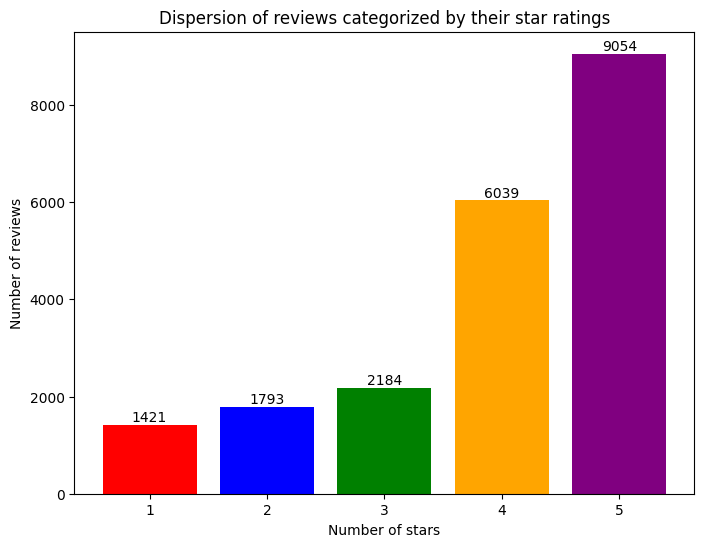

In [5]:
# Filter the data to include only classes 1, 2, 3, 4, and 5
filtered_data = df[df['Rating'].isin([1, 2, 3, 4, 5])]

# Create a bar chart for the 'Rating' column with counts
plt.figure(figsize=(8, 6))

# Define colors for each class
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Calculate counts for each class
class_counts = []
for rating in [1, 2, 3, 4, 5]:
    subset = filtered_data[filtered_data['Rating'] == rating]
    count = len(subset)
    class_counts.append(count)

# Create a bar chart with counts
bars = plt.bar([1, 2, 3, 4, 5], class_counts, color=colors)
plt.title("Dispersion of reviews categorized by their star ratings")
plt.xlabel("Number of stars")
plt.ylabel("Number of reviews")
plt.xticks(range(1, 6))

# Annotate each bar with its count
for bar, count in zip(bars, class_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(count),
             ha='center', va='bottom')

plt.show()


### Observations 

We observe a class imbalance: many more reviews with 4 or 5 stars than reviews with 1, 2 or 3 stars, and this can affect the ability of prediction models to generalize correctly. In such situations, models may have a tendency to favor the majority class (4 or 5 stars) and have lower performance in predicting minority classes (1, 2 or 3 stars). This can result in biased or less accurate results for less represented classes.

### Options of solutions

To alleviate this class imbalance we have 3 different solutions :

1. Undersampling: You could randomly reduce the number of samples in over-represented classes to balance the classes. However, this may result in potential information loss.
Our dataset presents more than two classes and two of them are considered the majority, we can use specific techniques to handle this situation. The objective is to subsample these majority classes in order to balance the dataset.
The imbalanced-learn library provides options for handling multiple majority classes. The use of specific techniques depends on the situation and data. 
Here are some strategies:

- RandomUnderSampler
- ClusterCentroids
- TomekLinks

2. Oversampling: You could increase the number of samples in underrepresented classes by replicating or creating synthetic data (for example, using the SMOTE technique) to balance the classes. However, this can lead to overfitting if the synthetic data does not accurately represent the real characteristics of the minority class.

3. Weighting of classes: Some algorithms allow additional weight to be given to classes less represented during training, to compensate for the imbalance.

### Chosen solutions

We decide to first :

1. Undersampling :

We will use TomekLinks which has the advantages to dentify and remove close pairs, maintain clear boundaries between classes.
His disadvantages is that it may not be effective for high-dimensional datasets but our dataset will not be too big after Undersampling.


Then we will use the processus of : 

2. Weighting of classes :

It will give additional weight to classes less represented during training. In Python, certain scikit-learn models support class weighting, we will test with the case of SVM or logistic regression which both use the class: class_weight='balanced', thanks to the imbalanced-learn library allowing to perform resampling operations

## ***Train/test split***

### Encoding labels

We want to encode the class labels and create a train/test split

In [34]:
# instantiate a label encoder # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
label_encoder = LabelEncoder()

# fit and transform the encoder on labels
df['Review_enc'] = label_encoder.fit_transform(df['Rating'])

### Split arrays or matrices into random train and test subsets.

In [35]:
# Define class labels
class_labels = ["1 star","2 stars","3 stars","4 stars","5 stars"]
category_orders = {"Review": class_labels}

# Split the data into training and testing sets
X = df['Review']
y = df['Review_enc']


## Undersampling with TomekLinks

In [ ]:
# Define desired ratio for 4-stars class and 5-stars class
desired_ratio_4_stars = 0.38
desired_ratio_5_stars = 0.255
tomek = TomekLinks(sampling_strategy={'4 stars': desired_ratio_4_stars, '5 stars': desired_ratio_5_stars})
X_under, y_under = tomek.fit_resample(X, y)

## ***Class Definition***

We'll create a class Model in order to test different Vectorizer and Model architecture. 
In this class we'll define a pipeline. This pipeline will take raw reviews as input, preprocess and vectorize them, before fitting a classification model to it.
The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.

In [40]:
from classes import Model

## Choice for random_seed

By setting a random seed (random_seed=42), we'll guarantee that random operations in our code (like randomly splitting the data into training and testing sets) will give the same results each time they run, provided that the rest of the code is the same. This is useful for reproducibility of experiments.

## Choice for test-size

The test_size is used to specify the proportion of the data that will be allocated to the test set when splitting the data. 
We will put test_size=0.2, it means that 20% of the data will be used as the test set and the rest (80%) will be the training set.

## Choices for Model Architecture

Because of class imbalanced seeing before when exploring the data, we want to gives additional weight to classes less represented during training, so we will first favor the use of these models : 

- Logistic Regression

and 

- SVM.

## Options for Vectorizer

We are going to test the commonly used NLP solutions for text vectorization below :

- CountVectorizer and TfidfVectorizer (scikit-learn):
CountVectorizer counts the number of occurrences of each word in the document.
TfidfVectorizer (Term Frequency-Inverse Document Frequency) takes into account the frequency of the term in a document and its rarity in the entire corpus.

- Word Embeddings:
Word2Vec, GloVe, FastText: These techniques represent words as vectors in a continuous vector space, capturing semantic relationships between words.
BERT, GPT (pre-trained language models): They provide extremely rich word/context representations and are suitable for various NLP tasks.

- Doc2Vec:
Doc2Vec (Paragraph Vector): It is an extension of Word2Vec that allows you to learn vector representations of entire documents.

## Model with LogisticRegression and TF-IDF

To begin we will use Logistic regression model in order to use class_weight='balanced', and Tf-idf Vectorizer 

In [43]:
# instantiate the Model class with text and labels (X and y), a logistic regression model and a tfidf vectorizer
model_clf2 = Model(X, y, LogisticRegression(class_weight='balanced', solver='liblinear'), TfidfVectorizer(preprocessor=preprocess_text), random_seed=42, test_size=0.2)

# fit the model
model_clf2.fit()

# predict and generate classification report
model_clf2.report(class_labels)

              precision    recall  f1-score   support

      1 star       0.68      0.68      0.68       292
     2 stars       0.42      0.49      0.45       333
     3 stars       0.38      0.35      0.36       432
     4 stars       0.58      0.47      0.52      1252
     5 stars       0.73      0.83      0.78      1790

    accuracy                           0.63      4099
   macro avg       0.56      0.56      0.56      4099
weighted avg       0.62      0.63      0.62      4099



The results are not bad ! We can quite observe a good diagonal, we are not suprised that there are lot of results on 5 stars class we saw that on the histogram before.
Nevertheless, we can see that in proportion, the model is making :

- small mistakes when choosing between 1-stars and 2 stars classes or between 2 and 3 stars classes, 
- medium mistakes when choosing between the 3-star and 4-stars class
- big mistake when choosing between 4 and 5 stars class

## Model with LogisticRegression and CountVectorizer

Let's try Logistic regression model in order to still use class_weight='balanced' but this time with CountVectorizer.

In [44]:
# instantiate the Model class with text and labels (X and y), a logistic regression model and a tfidf vectorizer
model_clf2 = Model(X, y, LogisticRegression(class_weight='balanced', solver='liblinear'), CountVectorizer(preprocessor=preprocess_text), random_seed=42, test_size=0.2)

# fit the model
model_clf2.fit()

# predict and generate classification report
model_clf2.report(class_labels)

              precision    recall  f1-score   support

      1 star       0.68      0.61      0.64       292
     2 stars       0.37      0.36      0.37       333
     3 stars       0.32      0.32      0.32       432
     4 stars       0.50      0.43      0.46      1252
     5 stars       0.70      0.78      0.74      1790

    accuracy                           0.58      4099
   macro avg       0.51      0.50      0.51      4099
weighted avg       0.57      0.58      0.57      4099



It look like Count Vectorizer does not make better results...and it also look worse when differenciating 4-stars class and 5-stars class.

## Confirm the use of Logistic regression : Model with CountVectorizer and Multimodal Naive Bayes

We test a model without a logistic regression for example with MNB :

- MultinomialNB which is a naive Bayesian multinomial classifier, suitable for text classification and often used in tasks such as document categorization

## Model with MultinomialNB and TF-IDF

In [17]:
# instantiate the Model class with text and labels (X and y), a multinomial naive bayes model and a tfidf vectorizer
model_clf = Model(X, y, MultinomialNB(), TfidfVectorizer(preprocessor=preprocess_text),random_seed=42, test_size=0.2)

# fit the model
model_clf.fit()

# predict and generate classification report
model_clf.report(class_labels)

/Users/mac/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/mac/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/mac/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

      1 star       1.00      0.00      0.01       292
     2 stars       0.00      0.00      0.00       333
     3 stars       0.00      0.00      0.00       432
     4 stars       0.15      0.02      0.03      1252
     5 stars       0.45      1.00      0.62      1790

    accuracy                           0.44      4099
   macro avg       0.32      0.20      0.13      4099
weighted avg       0.31      0.44      0.28      4099



Without Logistic regression, we don't even have a diagonal result.
Let's try change the vectorizer with countvectorizr

In [29]:
# instantiate the Model class with text and labels (X and y), a multinomial naive bayes model and a tfidf vectorizer
model_clf = Model(X, y, MultinomialNB(), CountVectorizer(preprocessor=preprocess_text))

# fit the model
model_clf.fit()

# predict and generate classification report
model_clf.report(class_labels)

              precision    recall  f1-score   support

      1 star       0.83      0.42      0.56       292
     2 stars       0.39      0.34      0.37       333
     3 stars       0.36      0.09      0.15       432
     4 stars       0.47      0.51      0.49      1252
     5 stars       0.69      0.85      0.76      1790

    accuracy                           0.60      4099
   macro avg       0.55      0.44      0.46      4099
weighted avg       0.58      0.60      0.57      4099



Countvectorizer seems to gives much result, but the diagonal is still less performant than with a logistic regression

## 